<a href="https://colab.research.google.com/github/Danhh-zk/LMH_Summer_Oxford_RL/blob/main/5_ActorCritic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Contents: Actor Critic

In this notebook, you will implementa basic Actor Critic Reinforcement learning algorithm for Lunar Lander Environment.

Write the code to define and train the agent.
Make sure to include a visualization of the end result in form of a video.

## Lunar Lander

This environment is a classic rocket trajectory optimization problem. The landing pad is always at coordinates (0,0). The state is an 8-dimensional vector: the coordinates of the lander in x & y, its linear velocities in x & y, its angle, its angular velocity, and two booleans that represent whether each leg is in contact with the ground or not.

There are four discrete actions available:<br>
- 0: do nothing<br>
- 1: fire left orientation engine<br>
- 2: fire main engine<br>
- 3: fire right orientation engine<br>

After every step a reward is granted. The total reward of an episode is the sum of the rewards for all the steps within that episode.

For each step, the reward:

- is increased/decreased the closer/further the lander is to the landing pad.

- is increased/decreased the slower/faster the lander is moving.

- is decreased the more the lander is tilted (angle not horizontal).

- is increased by 10 points for each leg that is in contact with the ground.

- is decreased by 0.03 points each frame a side engine is firing.

- is decreased by 0.3 points each frame the main engine is firing.

The episode receive an additional reward of -100 or +100 points for crashing or landing safely respectively.

An episode is considered a solution if it scores at least 200 points.


You can read more the cartpole environment [here](https://gymnasium.farama.org/environments/box2d/lunar_lander/)

![Cartpole](https://gymnasium.farama.org/_images/lunar_lander.gif)

## Creating the Environment

In [2]:
!pip install -q swig
!pip install -q gym[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 24.2 MB/s eta 0:00:00


In [5]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import deque, namedtuple

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.distributions import Categorical

In [6]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
# Create the environment
env = gym.make("LunarLander-v2")

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


### Solve here

write the code to define and train the agent:

In [ ]:
# Actor
# takes the current state as input and outputs the probabilities of selecting each possible action.- learns to output an optimal policy
# actions that maximize the expected future rewards.

# Ci
# evaluating the quality of the actions taken by the agent.
# takes the current state as input and outputs a single value, representing the estimated value or expected return of the current state.
# learns to accurately predict the expected future rewards, which is used to guide the learning of the actor.

In [ ]:
# The actor component outputs the probabilities of each action, which can be used to sample an action or select the action with the highest probability.
# The critic component outputs the estimated value of the current state, which is used to update the actor's policy during training.

# returning both the action probabilities and the state value, this implementation allows the agent to use both the policy gradient and value-based updates to learn an optimal policy and value function.

In [16]:
class ActorCritic(nn.Module):
    """
    implements both actor and critic in one model
    """
    def __init__(self, n_observations, n_actions):
        super(ActorCritic, self).__init__()
        self.affine1 = nn.Linear(n_observations, 128)

        # actor's layer
        self.action_head = nn.Linear(128, n_actions) #different actions the agent can take.

        # critic's layer
        self.value_head = nn.Linear(128, 1) #  estimated value or expected return of the current state, which is used by the critic component of the reinforcement learning agent.

    def forward(self, x):
        """
        forward of both actor and critic
        """
        x = F.relu(self.affine1(x))

        # actor: choses action to take from state s_t
        # by returning probability of each action
        # The self.action_head(x) part takes the input x (current state) and
        # passes it through the actor's neural network layer to obtain the logits or unnormalized log-probabilities for each action.

        action_prob = F.softmax(self.action_head(x), dim=-1)  # action_prob : each element represents the probability of taking the corresponding action


        # critic: evaluates being in the state s_t
        # by returning a single value
        # The self.value_head(x) part takes the input x (current state) and
        # passes it through the critic's neural network layer to obtain the estimated value or expected return of the current state.

        state_values = self.value_head(x)

        # return values for both actor and critic as a tuple of 2 values:
        # 1. a list with the probability of each action over the action space
        # 2. the value from state s_t
        return action_prob, state_values


    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs, state_value = self.forward(state)
        # create a categorical distribution over the list of probabilities of actions
        m = Categorical(probs) # probability of each action.
        # and sample an action using the distribution
        action = m.sample()
        return action.item(), m.log_prob(action), state_value.squeeze(0) # probability of the selected action. # estimated state value

In [9]:
# Here, we will specify the hyperparameters

total_episodes = 1000        # Total training episodes
max_steps = 500              # Max steps per episode
learning_rate = 1e-2         # Learning rate|
gamma = 0.99                 # Discounting rate
update_steps = 3 # the agent will update its policy and value function parameters after every 3 steps.

In [10]:
print('observation space:', env.observation_space)
print('action space:', env.action_space)

state_size = env.observation_space.shape[0]
action_size = env.action_space.n
print('state size:', state_size)
print('action size:', action_size)

observation space: Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)
action space: Discrete(4)
state size: 8
action size: 4


In [11]:
# Intialize policy network
actor_critic = ActorCritic(state_size, action_size).to(device)

# set up the optimizer
optimizer = optim.Adam(actor_critic.parameters(), lr=learning_rate)

In [12]:
scores = []

loss = 0

for episode in range(1, total_episodes+1):
  saved_log_probs = []
  rewards = []
  saved_buffer = {'log_prob':[], 'value':[]}
  state = env.reset()
  # collect trajectory
  for t in range(max_steps):
    # sample action and its log probability from policy
    action, log_prob, value = actor_critic.act(state) # Selects an action using the actor_critic.act() function, which returns the action, its log probability, and the value estimate.
    state, reward, done, _ = env.step(action)
    rewards.append(reward)
    # Stores the log probability and value estimate
    saved_buffer["log_prob"].append(log_prob)
    saved_buffer["value"].append(value)
    if done:
        break

  scores.append(sum(rewards))

  # Compute the discounted returns at each timestep
  returns = deque(maxlen=max_steps)
  n_steps = len(rewards)
  # We will use the dynamic programming approach to reduce complexity of this operation.
  # We calculate from last to first and avoid redundant computations that would be needed
  # if we were to do it from first to last.

  for t in range(n_steps)[::-1]:
    disc_return_t = (returns[0] if len(returns)>0 else 0)
    returns.appendleft( gamma*disc_return_t + rewards[t]   )

    # If the list is empty, it sets the discounted return to 0. Otherwise, it takes the first element of the returns list, which represents the discounted return for the next time step.

  ## standardization of the returns is employed to make training more stable
  eps = np.finfo(np.float32).eps.item()
  ## eps is the smallest representable float, which is
  # added to the standard deviation of the returns to avoid numerical instabilities
  returns = torch.tensor(returns)
  returns = (returns - returns.mean()) / (returns.std() + eps)

  policy_losses = [] # list to save actor (policy) loss
  value_losses = [] # list to save critic (value) loss

  # saved_buffer["log_prob"]: This contains the log probabilities of the actions taken by the agent during the episode.
   # saved_buffer["value"]: This contains the estimated state values (critic output) for the states encountered during the episode.

  for log_prob, value, R in zip(saved_buffer["log_prob"], saved_buffer["value"], returns):
    # line calculates the advantage for the current time step
    advantage = R - value.item()

    # calculate actor (policy) loss
    policy_losses.append(-log_prob * advantage)

    # calculate critic (value) loss using L1 smooth loss
    value_losses.append(F.smooth_l1_loss(value, torch.tensor([R], device=device)))

  # sum up all the values of policy_losses and value_losses
  loss += torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()

  if episode % update_steps  == 0:
    # Back propagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss = 0


  print(f"Episode {episode}: Reward = {scores[-1]}")


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 1: Reward = -323.3071020456498
Episode 2: Reward = -331.58406178523626
Episode 3: Reward = -272.2433163771701
Episode 4: Reward = -130.52858215545214
Episode 5: Reward = -202.53141834703192
Episode 6: Reward = -78.01296024603965
Episode 7: Reward = -65.69071005815962
Episode 8: Reward = -177.2709894336555
Episode 9: Reward = -163.94793833008447
Episode 10: Reward = -366.7177044100038
Episode 11: Reward = -158.66293123510698
Episode 12: Reward = -108.14101579679469
Episode 13: Reward = -170.17632554725174
Episode 14: Reward = -192.95686200950678
Episode 15: Reward = -251.94106804220092
Episode 16: Reward = -208.15322313664663
Episode 17: Reward = -444.4432473915403
Episode 18: Reward = -103.297164514109
Episode 19: Reward = -89.21220950601757
Episode 20: Reward = -86.18013626077321
Episode 21: Reward = -206.93740068872896
Episode 22: Reward = -235.43670970727553
Episode 23: Reward = -282.5603438844655
Episode 24: Reward = -109.20076988514724
Episode 25: Reward = -42.539967915466

Text(0, 0.5, 'Reward')

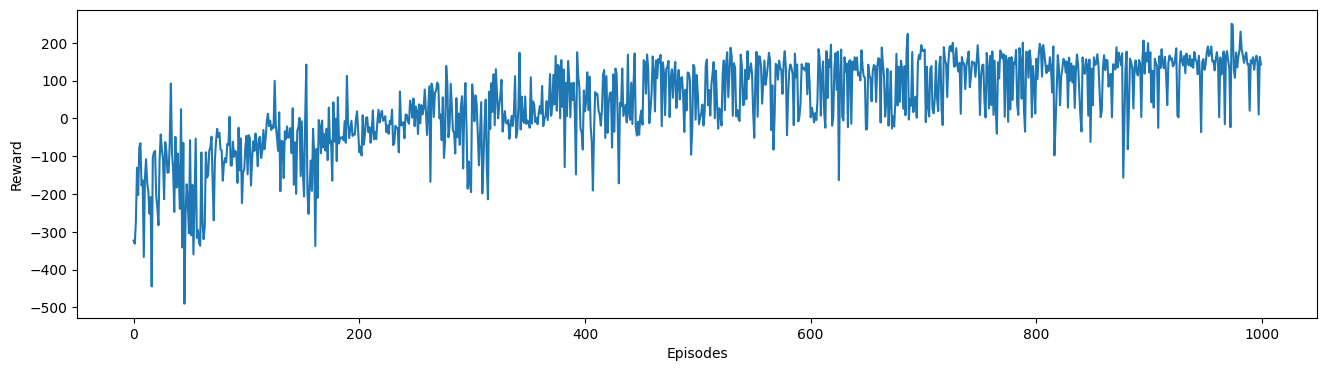

In [13]:
plt.figure(figsize=(16,4))
plt.plot(scores)
plt.xlabel("Episodes")
plt.ylabel("Reward")

### Visualization

You are provided with some functions which will help you visualize the results as a video.
Feel free to wrie your own code for visualization if you prefer

In [14]:
# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob
import base64, io, os

os.environ['SDL_VIDEODRIVER']='dummy'

In [22]:
os.makedirs("video", exist_ok=True)

def show_video(env_name):
    # Function to show a video in the notebook. Do not modify.
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = 'video/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

def show_video_of_model(env_name, max_steps=500):
    vid = video_recorder.VideoRecorder(env, path="video/{}.mp4".format(env_name))
    state = env.reset()
    done = False
    for t in range(max_steps):
        vid.capture_frame()

        # Write your code to choose an action here.
        action, log_prob, state_value = actor_critic.act(state)


        next_state, reward, done, info = env.step(action)
        # print(f"state: {state}, action: {action}",next_state, reward, done)
        state = next_state
        if done:
            break
    vid.close()
    env.close()

In [23]:
show_video_of_model("LunarLander-v2")

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead

In [24]:
show_video("LunarLander-v2")